In [ ]:
!pip install pybullet
!pip install gymnasium pybullet stable-baselines3[extra]

In [ ]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import pybullet as p
import pybullet_data
import time
from stable_baselines3 import PPO
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [5]:
class CupGraspingEnv(gym.Env):
    def __init__(self):
        super(CupGraspingEnv, self).__init__()

        self.client = p.connect(p.DIRECT)
        p.setAdditionalSearchPath(pybullet_data.getDataPath())

        # AXYZ 이동 + 그리퍼
        action_bound = 0.1
        self.action_space = spaces.Box(
            low=np.array([-action_bound]*3 + [0]),
            high=np.array([action_bound]*3 + [1]),
            shape=(4,),
            dtype=np.float32
        )

        # Observation Space : 그리퍼(3), 컵(3), 관절각도(9), 그리퍼 상태(1), 상대위치(3) -> 총 19차원
        obs_dim = 3 + 3 + 9 + 1 + 3
        obs_low = np.array([-np.inf] * obs_dim)
        obs_high = np.array([np.inf] * obs_dim)
        self.observation_space = spaces.Box(low=obs_low, high=obs_high, dtype=np.float32)

        self.robotId = None
        self.cupId = None
        self.end_effector_index = 8 # Panda 로봇의 손목 바로 위 링크
        self.gripper_indices = [9, 10] # Panda 로봇의 손가락 관절
        self.distance_to_cup = 0
        self.max_steps_per_episode = 500
        self.step_counter = 0
        print("맞춤형 Gym 환경이 [Panda Grasping 버전]으로 생성되었습니다!")

    def reset(self, seed=None, options=None):
        self.step_counter = 0
        p.resetSimulation(physicsClientId=self.client)
        p.setGravity(0, 0, -9.8)
        self.planeId = p.loadURDF("plane.urdf")
        p.loadURDF("plane.urdf")
        self.robotId = p.loadURDF("franka_panda/panda.urdf", [0, 0, 0], useFixedBase=True)

        rand_x = np.random.uniform(0.45, 0.55) # 기존 0.4~0.6보다 좁은 범위
        rand_y = np.random.uniform(0.15, 0.25) # 기존 0.1~0.3보다 좁은 범위
        cup_start_pos = [rand_x, rand_y, 0.05]
        cup_visual_shape = p.createVisualShape(p.GEOM_CYLINDER, radius=0.04, length=0.1, rgbaColor=[0.8, 0.2, 0.2, 1])
        cup_collision_shape = p.createCollisionShape(p.GEOM_CYLINDER, radius=0.04, height=0.1)
        self.cupId = p.createMultiBody(baseMass=0.1, baseCollisionShapeIndex=cup_collision_shape, baseVisualShapeIndex=cup_visual_shape, basePosition=cup_start_pos)

        # 마찰력을 설정
        p.changeDynamics(self.cupId, -1, lateralFriction=1.0)
        p.changeDynamics(self.robotId, self.gripper_indices[0], lateralFriction=1.0)
        p.changeDynamics(self.robotId, self.gripper_indices[1], lateralFriction=1.0)

        observation = self._get_obs()
        self.distance_to_cup = np.linalg.norm(self.gripper_pos - self.cup_pos)
        # 1. 조명 랜덤화: 조명의 방향, 색상, 강도를 무작위로 변경
        light_direction = [np.random.uniform(-1, 1) for _ in range(3)]
        light_color = [np.random.uniform(0.5, 1) for _ in range(3)]
        p.configureDebugVisualizer(lightPosition=light_direction)

        # 2. 색상/텍스처 랜덤화: 바닥, 로봇, 컵의 색상을 무작위로 변경
        plane_color = list(np.random.rand(4))
        plane_color[3] = 1
        p.changeVisualShape(self.planeId, -1, rgbaColor=plane_color)

        robot_color = list(np.random.rand(4))
        robot_color[3] = 1
        # 로봇의 모든 링크 색상을 변경
        for i in range(p.getNumJoints(self.robotId)):
            p.changeVisualShape(self.robotId, i, rgbaColor=robot_color)

        cup_color = list(np.random.rand(4))
        cup_color[3] = 1
        p.changeVisualShape(self.cupId, -1, rgbaColor=cup_color)

        info = {}
        return observation, info

    def step(self, action):
        # action 벡터를 이동과 잡기 부분으로 분리
        move_action = action[:3]  # XYZ 이동량
        grasp_action = action[3]   # 그리퍼 제어 (0~1 사이 값)

        current_gripper_state = p.getLinkState(self.robotId, self.end_effector_index)
        current_gripper_pos = np.array(current_gripper_state[0])
        target_position = current_gripper_pos + move_action
        target_joint_angles = p.calculateInverseKinematics(self.robotId, self.end_effector_index, target_position)

        if target_joint_angles:
            p.setJointMotorControlArray(
                bodyIndex=self.robotId,
                jointIndices=range(self.end_effector_index + 1), # 0~6번 팔 관절
                controlMode=p.POSITION_CONTROL,
                targetPositions=target_joint_angles[:self.end_effector_index + 1]
            )

        target_gripper_pos = 0.00 if grasp_action > 0.5 else 0.04
        p.setJointMotorControlArray(
            bodyIndex=self.robotId,
            jointIndices=self.gripper_indices, # 그리퍼 관절만 제어
            controlMode=p.POSITION_CONTROL,
            targetPositions=[target_gripper_pos] * len(self.gripper_indices)
        )

        p.stepSimulation()

        observation = self._get_obs()
        reward = self._compute_reward()
        terminated = self._check_done()
        info = {}
        return observation, reward, terminated, False, info

    def _get_obs(self):
        gripper_state = p.getLinkState(self.robotId, self.end_effector_index)
        self.gripper_pos = np.array(gripper_state[0])

        cup_pos, _ = p.getBasePositionAndOrientation(self.cupId)
        self.cup_pos = np.array(cup_pos)

        joint_states = p.getJointStates(self.robotId, range(p.getNumJoints(self.robotId)))

        # Panda 로봇의 움직이는 관절 9개(팔 7 + 그리퍼 2)
        joint_positions = [state[0] for state in joint_states][:9]
        gripper_joint_state = p.getJointState(self.robotId, self.gripper_indices[0])
        gripper_opening = np.array([gripper_joint_state[0]])
        # 그리퍼에서 컵을 향하는 '상대 위치 벡터'를 계산하여 추가
        relative_pos = self.cup_pos - self.gripper_pos
        # 계산된 relative_pos를 observation에 포함
        observation = np.concatenate([self.gripper_pos, self.cup_pos, joint_positions, gripper_opening, relative_pos])

        return observation

    def _compute_reward(self):
        reward = 0

        gripper_state = p.getLinkState(self.robotId, self.end_effector_index)
        self.gripper_pos = np.array(gripper_state[0])
        cup_pos, cup_orn = p.getBasePositionAndOrientation(self.cupId)
        self.cup_pos = np.array(cup_pos)
        gripper_joint_state = p.getJointState(self.robotId, self.gripper_indices[0])

        new_distance = np.linalg.norm(self.gripper_pos - self.cup_pos)

        # 접근 보상 (더 조밀하게)
        reward += (self.distance_to_cup - new_distance) * 100  # 변화량 보상
        reward += -new_distance * 50  # 현재 거리에 대한 페널티
        self.distance_to_cup = new_distance

        # 시간 페널티
        reward -= 0.5

        is_gripper_closing = gripper_joint_state[0] < 0.01
        contact_points = p.getContactPoints(bodyA=self.robotId, bodyB=self.cupId)
        is_contacting = len(contact_points) > 0
        num_contacts = len(contact_points)

        # [새로운] Z축 정렬 보상: 그리퍼가 컵 위쪽에 위치하도록 유도 (잡기 전 단계)
        z_diff = abs(self.gripper_pos[2] - (self.cup_pos[2] + 0.05))  # 컵 상단 높이 0.05 목표
        if new_distance < 0.1:  # 근처에서만 적용
            reward += -z_diff * 100  # Z축 차이만큼 페널티 (0에 가까울수록 좋음)
            if z_diff < 0.03:
                print("--- [정렬 단계] 그리퍼가 컵 상단에 정렬됨! ---")
                reward += 50  # 정렬 성공 보너스

        # [단계 1] 잡기 시도 보상: 컵 근처에서 손가락을 오므리는 '의도'를 더 강하게 칭찬
        if new_distance < 0.06 and z_diff < 0.05 and is_gripper_closing:  # 거리 기준 강화 + Z 정렬 조건 추가
            print("--- [단계 1] 잡기 시도! ---")
            reward += 100  # 보상 증가

        # [단계 2] 잡기 성공 보상: '잡는 상태' 자체를 더 세밀하게 칭찬
        if is_contacting and is_gripper_closing:
            print("--- [단계 2] 컵과 접촉 및 잡기 성공! ---")
            reward += 300 + num_contacts * 50  # 접촉 포인트 수에 비례

        # [단계 3] 들어 올리기 보상: 최종 목표 달성을 칭찬
        is_cup_lifted = cup_pos[2] > 0.05
        if is_contacting and is_gripper_closing and is_cup_lifted:
            lift_height = cup_pos[2] - 0.05  # 초기 높이 기준 상승량
            print("--- [단계 3] 컵을 들어 올리는 중! ---")
            reward += lift_height * 2000  # 높이 비례 보상 증가

            cup_vel, _ = p.getBaseVelocity(self.cupId)
            upward_vel = cup_vel[2]  # Z축 속도 (위로 움직일수록 좋음)
            if upward_vel > 0:
                reward += upward_vel * 100  # 위로 움직이는 모멘텀 보상

            # [단계 4] 충분히 높이 들어 올리면 최종 성공
            if cup_pos[2] > 0.1:
                print("***** [최종 성공] 컵을 완전히 들어 올렸습니다! *****")
                reward += 10000

        # 실패 페널티
        cup_euler = p.getEulerFromQuaternion(cup_orn)
        if abs(cup_euler[0]) > 0.5 or abs(cup_euler[1]) > 0.5:
            reward -= 500

        return reward

    def _check_done(self):
        cup_pos, cup_orn = p.getBasePositionAndOrientation(self.cupId)

        if cup_pos[2] > 0.1:
            return True

        # 실패 또는 시간 초과 조건
        cup_euler = p.getEulerFromQuaternion(cup_orn)
        if abs(cup_euler[0]) > 0.5 or abs(cup_euler[1]) > 0.5:
            return True

        self.step_counter += 1
        if self.step_counter > self.max_steps_per_episode:
            return True

        return False

    def render(self):
        view_matrix = p.computeViewMatrix(cameraEyePosition=[1,1,1], cameraTargetPosition=[0.5,0,0.5], cameraUpVector=[0,0,1])
        proj_matrix = p.computeProjectionMatrixFOV(fov=60.0, aspect=1.0, nearVal=0.1, farVal=100.0)
        (w, h, rgb, _, _) = p.getCameraImage(width=224, height=224, viewMatrix=view_matrix, projectionMatrix=proj_matrix)
        return rgb

    def close(self):
        if self.client >= 0:
            p.disconnect(self.client)
            self.client = -1
        print("PyBullet 시뮬레이션 연결이 종료되었습니다.")

In [ ]:
# --- AI 훈련 실행 (도메인 랜덤화 버전) ---
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import CheckpointCallback
import os

try:
    print("--- AI 훈련 시작 (도메인 랜덤화 적용) ---")

    # 1. 도메인 랜덤화가 적용된 최신 버전의 환경을 생성합니다.
    env = CupGraspingEnv()

    # 2. 모델을 저장할 Google Drive 경로 설정
    drive_save_path = '/content/drive/MyDrive/AI_Robotics_Project/domain_randomization_models/'
    os.makedirs(drive_save_path, exist_ok=True)

    # 3. 중간 저장을 위한 콜백 설정
    checkpoint_callback = CheckpointCallback(
      save_freq=50000,
      save_path=drive_save_path,
      name_prefix='ppo_cup_grasper_dr' # Domain Randomization 약자 'dr' 추가
    )

    # 4. PPO 모델을 '새로' 생성합니다.
    model = PPO(
        "MlpPolicy", env, verbose=1,
        gamma=0.99,
        learning_rate=0.0001,
        n_steps=4096
    )

    # 5. 훈련을 시작
    model.learn(total_timesteps=500000, callback=checkpoint_callback)

    # 6. 최종 훈련된 모델을 저장
    model.save(f"{drive_save_path}ppo_cup_grasper_dr_final")
    print(f"--- 훈련 완료! 최종 모델이 {drive_save_path}에 저장되었습니다. ---")

finally:
    env.close()

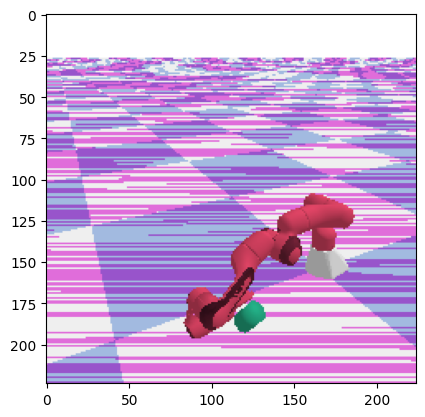

테스트 스텝: 100, 보상: -454.41, 종료 여부: True

***** 최종 성공! 컵 들어 올리기 완료! *****
PyBullet 시뮬레이션 연결이 종료되었습니다.
--- 테스트 종료 ---


In [16]:
# --- 훈련된 AI 성능 테스트 ---
try:
    print("\n--- 훈련된 AI 테스트 시작 ---")

    drive_model_path = '/content/drive/MyDrive/AI_Robotics_Project/domain_randomization_models/ppo_cup_grasper_dr_final.zip'
    trained_model = PPO.load(drive_model_path)
    print(f"모델 로드 완료: {drive_model_path}")

    test_env = CupGraspingEnv()
    obs, info = test_env.reset()

    # 최대 500 스텝 동안 1회의 에피소드를 테스트합니다.
    for i in range(test_env.max_steps_per_episode):
        action, _states = trained_model.predict(obs, deterministic=False)
        obs, reward, terminated, truncated, info = test_env.step(action)

        # --- 실시간 화면 보기 ---
        clear_output(wait=True)
        plt.imshow(test_env.render())
        plt.show()

        print(f"테스트 스텝: {i+1}, 보상: {reward:.2f}, 종료 여부: {terminated}")

        if terminated:
            # 최종 성공 여부 판단
            cup_pos, _ = p.getBasePositionAndOrientation(test_env.cupId)
            if cup_pos[2] > 0.05:
                print("\n***** 최종 성공! 컵 들어 올리기 완료! *****")
            else:
                print("\n--- 에피소드 실패 또는 시간 초과 ---")

            time.sleep(3) # 마지막 장면을 3초 동안
            break

        time.sleep(0.05)

finally:
    test_env.close()
    print("--- 테스트 종료 ---")

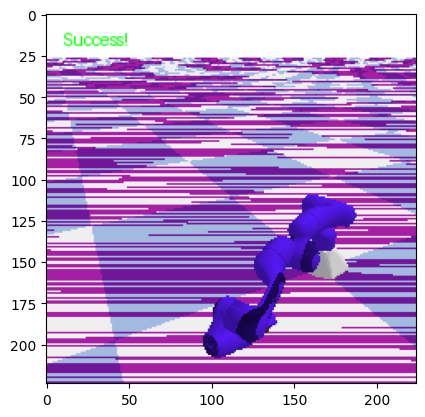

에피소드: 4, 스텝: 93
보상: 44.7491, 총 보상: 598.1425
종료 여부: True, 컵 높이: 0.0565
거리: 0.0706, Z 차이: 0.0022, 접촉: True, 그리퍼 닫힘: True
--- 에피소드 4: 성공! 컵을 0.0565m 들어 올림 ---
성공 GIF 저장: frames/success_episode_4.gif
--- 첫 성공 감지! 테스트 종료 ---
PyBullet 시뮬레이션 연결이 종료되었습니다.
--- 테스트 정상 종료 ---
PyBullet 시뮬레이션 연결이 종료되었습니다.
--- PyBullet 시뮬레이션 연결 종료 ---


In [12]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import pybullet as p
import pybullet_data
import time
from stable_baselines3 import PPO
import matplotlib.pyplot as plt
from IPython.display import clear_output
from PIL import Image, ImageDraw, ImageFont
import os
import imageio

try:
    print("\n--- 훈련된 AI 테스트 저장 ---")

    # 모델 로드
    drive_model_path = '/content/drive/MyDrive/AI_Robotics_Project/domain_randomization_models/ppo_cup_grasper_dr_final.zip'
    trained_model = PPO.load(drive_model_path)
    print(f"모델 로드 완료: {drive_model_path}")

    # 테스트 환경 생성
    test_env = CupGraspingEnv()
    obs, info = test_env.reset()

    # 다중 에피소드 테스트
    num_episodes = 10
    success_count = 0
    frame_dir = "frames"
    os.makedirs(frame_dir, exist_ok=True)  # 프레임 저장용 디렉토리

    for episode in range(num_episodes):
        print(f"\n--- 에피소드 {episode + 1} 시작 ---")
        obs, info = test_env.reset()
        total_reward = 0
        max_height = 0
        frames = []  # 성공 에피소드의 전체 프레임
        is_success = False

        for i in range(500):  # 환경의 max_steps_per_episode
            action, _states = trained_model.predict(obs, deterministic=False)
            obs, reward, terminated, truncated, info = test_env.step(action)
            total_reward += reward

            # 상태 확인
            cup_pos, _ = p.getBasePositionAndOrientation(test_env.cupId)
            max_height = max(max_height, cup_pos[2])
            contact_points = p.getContactPoints(bodyA=test_env.robotId, bodyB=test_env.cupId)
            is_contacting = len(contact_points) > 0
            gripper_joint_state = p.getJointState(test_env.robotId, test_env.gripper_indices[0])[0]
            is_gripper_closing = gripper_joint_state < 0.01

            # 디버깅 정보
            gripper_pos = test_env.gripper_pos
            cup_pos = test_env.cup_pos
            distance = np.linalg.norm(gripper_pos - cup_pos)
            z_diff = abs(gripper_pos[2] - (cup_pos[2] + 0.05))

            # 렌더링
            clear_output(wait=True)
            img = test_env.render()
            img_pil = Image.fromarray(img)

            # 성공 여부: 단계 3 조건
            if is_contacting and is_gripper_closing and cup_pos[2] > 0.05:
                is_success = True
                draw = ImageDraw.Draw(img_pil)
                try:
                    font = ImageFont.truetype("arial.ttf", 20)
                except:
                    font = ImageFont.load_default()
                draw.text((10, 10), "Success!", fill=(0, 255, 0), font=font)
                img = np.array(img_pil)

            # 프레임 저장
            frame_path = os.path.join(frame_dir, f"frame_ep{episode+1}_{i:04d}.png")
            plt.imsave(frame_path, img)
            frames.append(Image.open(frame_path))

            plt.imshow(img)
            plt.show()

            print(f"에피소드: {episode + 1}, 스텝: {i + 1}")
            print(f"보상: {reward:.4f}, 총 보상: {total_reward:.4f}")
            print(f"종료 여부: {terminated}, 컵 높이: {cup_pos[2]:.4f}")
            print(f"거리: {distance:.4f}, Z 차이: {z_diff:.4f}, 접촉: {is_contacting}, 그리퍼 닫힘: {is_gripper_closing}")

            if terminated or truncated:
                # 성공 기준: 단계 3 조건 재확인
                if is_success and is_contacting and is_gripper_closing and cup_pos[2] > 0.04:
                    print(f"--- 에피소드 {episode + 1}: 성공! 컵을 {cup_pos[2]:.4f}m 들어 올림 ---")
                    success_count += 1
                    # 성공 시 마지막 프레임 저장
                    frame_path = os.path.join(frame_dir, f"frame_ep{episode+1}_{i+1:04d}.png")
                    plt.imsave(frame_path, img)
                    frames.append(Image.open(frame_path))
                    # GIF 생성
                    gif_path = os.path.join(frame_dir, f"success_episode_{episode+1}.gif")
                    frames[0].save(
                        gif_path,
                        save_all=True,
                        append_images=frames[1:],
                        duration=33,  # 약 30fps
                        loop=0
                    )
                    print(f"성공 GIF 저장: {gif_path}")
                    print("--- 첫 성공 감지! 테스트 종료 ---")
                    test_env.close()
                    raise SystemExit
                else:
                    print(f"--- 에피소드 {episode + 1}: 실패 또는 시간 초과 (최대 높이: {max_height:.4f}m) ---")
                    if cup_pos[2] > 0.05:
                        print(f"--- 경고: 접촉={is_contacting}, 그리퍼 닫힘={is_gripper_closing} 상태로 높이 {cup_pos[2]:.4f}m 달성 ---")
                    # 실패 시 프레임 삭제
                    for frame in frames:
                        os.remove(frame.filename)

                time.sleep(1)
                break

        print(f"에피소드 {episode + 1} 종료, 총 보상: {total_reward:.4f}")


except SystemExit:
    print("--- 테스트 정상 종료 ---")
except Exception as e:
    print(f"오류 발생: {e}")
finally:
    test_env.close()
    print("--- PyBullet 시뮬레이션 연결 종료 ---")

In [13]:
from google.colab import files

file_to_download = 'frames/success_episode_4.gif'

try:
    files.download(file_to_download)
    print(f"'{file_to_download}' 파일 다운로드 요청을 보냈습니다.")
except FileNotFoundError:
    print(f"오류: '{file_to_download}' 파일을 찾을 수 없습니다.")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'frames/success_episode_4.gif' 파일 다운로드 요청을 보냈습니다.
